 Sections
--------
1. Load utils
2. Load data
3. Stack images
4. Training and Validation data sets
5. Build classifiers
6. Classification
7. Confusion matrix
8. Classification report

## Load utils

In [173]:
import rasterio
from rasterio.plot import show
import numpy as np
import pandas as pd
from rasterio.plot import reshape_as_image
import numpy as np
import geopandas as gp
# import  sklearn
import matplotlib.pyplot as plt

## Load data

In [49]:
# function to read the data with rasterio
def read_data(path):
    """ Reads the data from the given path and returns the data as a numpy array."""
    with rasterio.open(path) as src:
        data = src.read()
        return data#, src
        
rgb = read_data('raster/RGB.tif')
red, green, blue = read_data('raster/RGB.tif') #separate the bands
nir = read_data('raster/NIR3.tif')[0] 
reg = read_data('raster/REG3.tif')[0] # Red edge
# dsm = read_data('raster/DSM3.tif')[0].astype(np.float32)

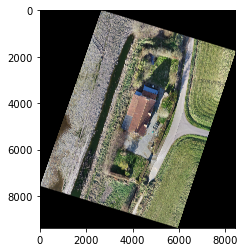

<AxesSubplot:>

In [59]:
show(rgb)

## Image stacking

The classification is based on the comparison of different band composite images.
```
- RGB
- RGB + NIR = rgb_nir
- RGB + REG = rgb_reg
- RGB + DSM = rgb_dsm
- RGB + DSM + NIR + REG = rgb_dsm_nir_reg
```

In [3]:
# nir_rgb = np.dstack((nir, red, green, blue))
# reg_rgb = np.dstack((reg, red, green, blue))
# rgb_dsm = np.dstack((red, green, blue, dsm))
# rgb_nir_reg_dsm = np.dstack((red, green, blue, nir, reg, dsm))

In [34]:
rgb = read_data('raster/RGB.tif')
red, green, blue = read_data('raster/RGB.tif') #separate the bands
nir = read_data('raster/NIR3.tif')[0] 
reg = read_data('raster/REG3.tif')[0] # Red edge

# read data into memory

### Normalization

In [57]:
# data normalization with min-max scaling
def normalize(data):
    """ Normalizes the data with min-max scaling."""
    data_min = data.min()
    data_max = data.max()
    data_norm = (data - data_min) / (data_max - data_min)
    return data_norm

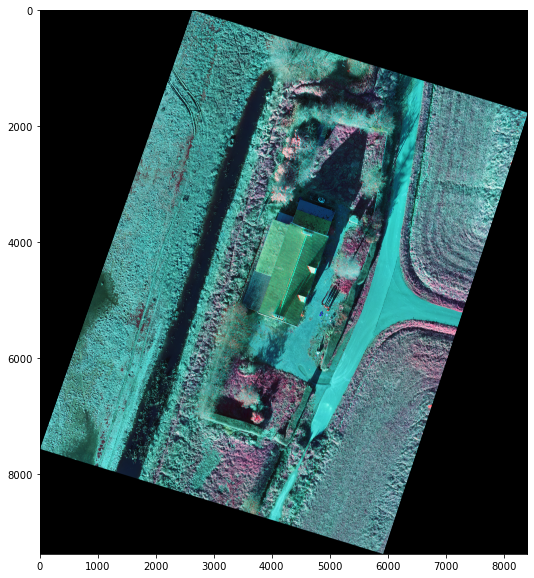

In [58]:
# np dstack
nir_rgb_norm = np.dstack((nir_norm, red_norm, green_norm,))

plt.figure(figsize=(25,10))
plt.imshow(nir_rgb_norm)
plt.show()

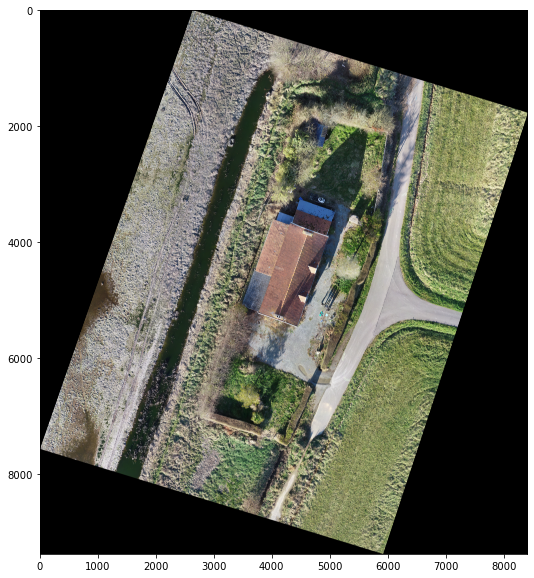

In [6]:
# plot rgb norm
rgb_norm = np.dstack((red_norm, green_norm, blue_norm,))
plt.figure(figsize=(25,10))
plt.imshow(rgb_norm)
plt.show()

## Training and Validation data sets

The few sampling points were selceted traninng (45) and validation (35); for training and validation set 7 andd 5 points were selected respectively.

In [9]:
# class name
class_name = ['grass', 'tree', 'roof', 'bush', 'water', 'road', 'sediment'] # seven classes

# training and validation paths
training_set_path = 'shapefile/training_set.shp'
validation_set_path = 'shapefile/validation_set.shp'

In [26]:
def normalize(data):
    """ Normalizes the data with min-max scaling."""
    data_min = data.min()
    data_max = data.max()
    data_norm = (data - data_min) / (data_max - data_min)
    return data_norm

In [181]:
import copy

def inmem(path):
    src = rasterio.open(path)
    img = src.read()   # load our original input file bands to a numby array stack
    # deep copy img to avoid changing the original data
    img_copy = copy.deepcopy(img)
    # normalise img
    img_norm = normalize(img_copy)
    src_profile = src.profile
    src_profile.update(dtype=rasterio.float64, nodata=np.nan)
    profile = src_profile  # the copy the profile of the original GeoTIFF input file
    with rasterio.io.MemoryFile() as memfile:
        with memfile.open(**profile) as dst:
            for i in range(0, src.count):
                dst.write(img_norm[i], i+1)
        dataset = memfile.open()
        return dataset, img_norm

In [182]:
# read rgb data into memory
rgb_mem, rsa = inmem('raster/RGB.tif')
# read nir data into memory
nir_mem, nir_rsa = inmem('raster/NIR3.tif')
# read reg data into memory
reg_mem, reg_rsa = inmem('raster/REG3.tif')
# read dsm data into memory
# dsm_mem, dsm_rsa = inmem('raster/DSM3.tif')

In [183]:
rgb_mem.shape
# rsa.dtype

(9370, 8404)

In [203]:
train_points = gp.read_file(training_set_path)
coords = [(x,y) for x,y in zip(train_points.geometry.x, train_points.geometry.y)]

def get_raster_value(coords, raster, train_points, bands):#, composite_raster = 'rgb'):
    """ Returns the raster value of the given coordinates."""
    # get the raster value as float for the given coordinates
    train_points['value'] = [x for x in raster.sample(coords)]
    train_points[bands] = pd.DataFrame(train_points['value'].values.tolist(), index=train_points.index)
    train_points = train_points.drop(['value'], axis=1)
    train_points = train_points.drop(['geometry'], axis=1)
    # train_points.to_csv('%s.csv'%composite_raster)
    return train_points

# rgb bands
rgb_bands = ['red', 'green', 'blue']
rgb_train_points = get_raster_value(coords, rgb_mem, train_points, rgb_bands)#, 'rgb')
# nir bands
nir_train_points = get_raster_value(coords, nir_mem, train_points, 'nir')
# # reg bands
reg_train_points = get_raster_value(coords, reg_mem, train_points, 'reg')
# dsm bands
# dsm_train_points = get_raster_value(coords, dsm_mem, train_points, 'dsm')

In [206]:
X  = train_points.drop(['class_code', 'value'], axis=1)
y = train_points['class_code']
# X

Validation set

In [207]:
validation_points = gp.read_file(validation_set_path)
coords = [(x,y) for x,y in zip(validation_points.geometry.x, validation_points.geometry.y)]

# validation rgb bands
rgb_validation_points = get_raster_value(coords, rgb_mem, validation_points, rgb_bands)#, 'rgb')
# validation nir bands
nir_validation_points = get_raster_value(coords, nir_mem, validation_points, 'nir')
# validation reg bands
reg_validation_points = get_raster_value(coords, reg_mem, validation_points, 'reg')
# validation dsm bands
# dsm_validation_points = get_raster_value(coords, dsm_mem, validation_points, 'dsm')

In [208]:
X_validation  = validation_points.drop(['class_code', 'value'], axis=1)
y_validation = validation_points['class_code']

## Build classifiers

### Random Forest

In [209]:
from sklearn.ensemble import RandomForestClassifier
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

def train_model(X_train, y_train):
    """ Trains a random forest model."""
    model = RandomForestClassifier(n_estimators=50, oob_score=True, max_features='auto', random_state=42)
    model.fit(X_train, y_train)
    return model
#train model
# for RGB
xtrain_rgb = X[['red', 'green', 'blue']]
rgb_model = train_model(xtrain_rgb, y)
# for RGB + NIR
xtrain_rgb_nir = X[['red', 'green', 'blue', 'nir']]
rgb_nir_model = train_model(xtrain_rgb_nir, y)
# for RGB + NIR + REG
xtrain_rgb_nir_reg = X[['red', 'green', 'blue', 'nir', 'reg']]
rgb_nir_reg_model = train_model(xtrain_rgb_nir_reg, y)

In [230]:
xtrain_rgb_nir.shape

(49, 4)

### Validation

In [229]:
# accuracy metrics sklearn
from sklearn.metrics import accuracy_score#, precision_score, recall_score, f1_score
def validation_model(X_validation, y_validation, model):
    """ Validates the model."""
    y_pred = model.predict(X_validation)
    accuracy = accuracy_score(y_validation, y_pred)
    print('Validation accuracy: %.2f' % accuracy)

#rgb validation
xval_rgb = X_validation[['red', 'green', 'blue']]
validation_model(xval_rgb, y_validation, rgb_model)
#rgb + nir validation
xval_rgb_nir = X_validation[['red', 'green', 'blue', 'nir']]
validation_model(xval_rgb_nir, y_validation, rgb_nir_model)
#rgb + nir + reg validation
xval_rgb_nir_reg = X_validation[['red', 'green', 'blue', 'nir', 'reg']]
validation_model(xval_rgb_nir_reg, y_validation, rgb_nir_reg_model)


Validation accuracy: 0.34
Validation accuracy: 0.40
Validation accuracy: 0.63


## Classification with models

In [ ]:
# color dictionary for class_code 
colors = dict((
    # roof
    (0, (255,0,0,255)), 
    # water
    (1, (0,76,153,255)),
    # road
    (2, (160,160,160,255)),
    # sediment
    (3, (255,204,153,255)),
    # Tree
    (4, (51,255,51,255)),
    # Grass
    (5, (0,255,0,255)),
    # bush
    (6, (204,255,153,255))
))

# convert 0-255 values to 0-1 values
for k, v in colors.items():
    colors[k] = [x/255 for x in v]

# matplotlib colormap from color dictionary
index_colors = [colors[x] if x in colors else (0,0,0,1) for x in range(0,7)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', 7)

##### Each model will be run on corresponding band combination

In [223]:
def read_input_combination(band_combination, x_subset):
    """ Returns the input combination based on input bands."""
    bands = band_combination.read()
    #reshape as (rows, cols, bands)
    band_reshaped = reshape_as_image(bands)
    # reshape as ((rows*cols), bands)
    input_raster = band_reshaped.reshape(-1, x_subset.shape[1])

    return input_raster

(3, 9370, 8404)
(9370, 8404, 3)
(78745480, 3)


In [225]:
# prediction on reshaped image using rgb model
class_rgb = rgb_model.predict(rr_reshaped)

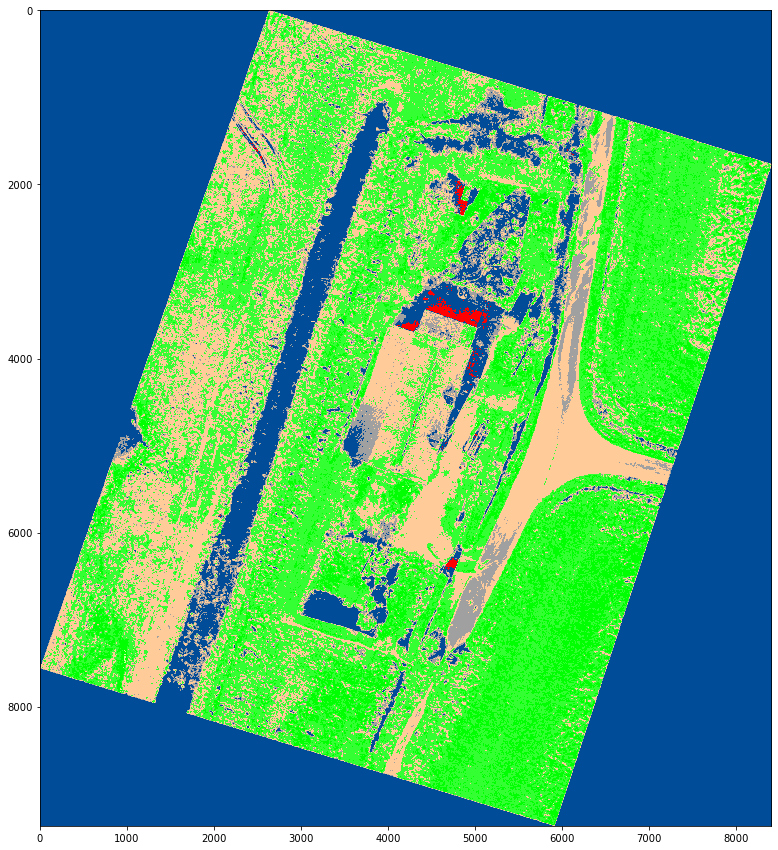

In [228]:
cl = class_rgb.reshape(rr[:,:,0].shape)
# plt.imshow(cl[1])
# cl
plt.figure(figsize=(15,15))
plt.imshow(cl, cmap=cmap)
plt.show()

## Confusion matrix

## Classification report